In [1]:
import torch
import pandas as pd
import numpy as np
import torch.utils
import torchvision.transforms
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Loading house prices training and test dataset
hptrain = pd.read_csv("Datasets/hptrain.csv",index_col=0)
hptest = pd.read_csv("Datasets/hptest.csv",index_col=0)

In [3]:
#Transforming data into tensor data format from pandas' dataframe
X_ols_train = torch.tensor(hptrain[['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'TotalBsmtSF']].values,requires_grad=True,dtype=torch.float32)
X_ols_train = nn.functional.normalize(X_ols_train)
Y_ols_train = torch.tensor(hptrain[['SalePrice']].values,requires_grad=True,dtype=torch.float32)


#Splitting data into iterable batches
olstensor = torch.utils.data.TensorDataset(X_ols_train,Y_ols_train)
olsdataloader = torch.utils.data.DataLoader(olstensor, batch_size=20,shuffle=True)

In [4]:
#Specifying the paramenters of our model
olsnet = nn.Sequential(nn.Linear(X_ols_train.size()[1],Y_ols_train.size()[1]))
olsnet[0].weight.data.normal_(0, 0.1)
olsnet[0].bias.data.normal_(0, 0.1)
olsloss = nn.MSELoss()
olstrainer = torch.optim.SGD(olsnet.parameters(),lr=0.0001)

In [5]:
num_epochs = 5
olsnet.train()
for epoch in range(num_epochs):
    print('-------------------')
    print(f'{epoch+1}th epoch')
    print('===================')
    olstrainer.zero_grad()
    X, Y = next(iter(olsdataloader))
    output = olsnet(X)

    l = olsloss(output,Y)
    print(f'Loss ols:{l}')


    l.backward(retain_graph=True)

    olstrainer.step()
    print('Coefficients: ',olsnet[0].weight.data)


-------------------
1th epoch
Loss ols:41172373504.0
Coefficients:  tensor([[ 3.7790e+01,  1.3982e-03, -1.6555e-01,  1.7050e-01,  4.0470e+00]])
-------------------
2th epoch
Loss ols:34931183616.0
Coefficients:  tensor([[ 7.2992e+01,  2.5006e-02, -1.4425e-01,  5.6796e-01,  7.6139e+00]])
-------------------
3th epoch
Loss ols:46612774912.0
Coefficients:  tensor([[ 1.1132e+02,  6.1287e-02, -1.1347e-01,  1.0936e+00,  1.3949e+01]])
-------------------
4th epoch
Loss ols:37875449856.0
Coefficients:  tensor([[ 1.4811e+02,  8.7077e-02, -9.1087e-02,  1.5955e+00,  1.8425e+01]])
-------------------
5th epoch
Loss ols:59439546368.0
Coefficients:  tensor([[ 1.9139e+02,  1.1764e-01, -6.6708e-02,  2.1800e+00,  2.3864e+01]])


In [6]:
'''--------------------------------------------------------'''
'''--------------------------------------------------------'''
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [7]:
#Loading in complex MNIST train and test datasets while transforming them to 64
trans = [torchvision.transforms.ToTensor()]
trans.insert(0, torchvision.transforms.Resize(28))
trans = torchvision.transforms.Compose(trans)


mnist_train = torchvision.datasets.FashionMNIST(
    root="../PyTorch_Basic/Datasets",train = True, transform=trans, download= True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../PyTorch_Basic/Datasets",train = False, transform=trans, download= True)

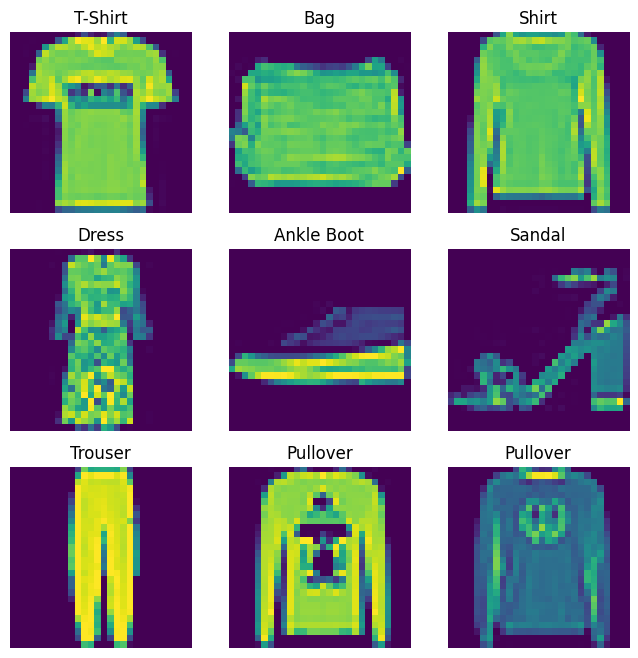

In [8]:
#Visualizing 9 random examples

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()



In [9]:
#Splitting our data into batch sizes
mnist_batch_size = 9

mnist_train_iter = torch.utils.data.DataLoader(mnist_train,mnist_batch_size,shuffle=True,num_workers=4)
mnist_test_iter = torch.utils.data.DataLoader(mnist_test,mnist_test.__len__(),shuffle=False,num_workers=4)

In [10]:
#Creating the model and initializing the weights
logit_net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))

#Initializing weights
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

logit_net.apply(init_weights)

#Specifying cross entropy loss
logit_loss = nn.CrossEntropyLoss(reduction='none')

#Specifying Stochastic Gradient Descent trainer
logit_trainer = torch.optim.SGD(logit_net.parameters(), lr=0.1)

In [18]:
#Creating a class for displaying the results
class evaluation:
    """For evaluating the accuracy of image recognition neural networks which use Cross-Entropy Loss"""
    def __init__(self,net,img = None,label = None):
        #History of saved error rates, used for in-sample error evaluation during neural network training
        self.hist = []
        self.net = net
        self.img = img
        self.label = label
    def prob(self):
        """Returns probabilities for each label"""
        output = self.net(img)
        exp = torch.exp(output)
        probabilities = exp / sum(exp)
        return probabilities
    def pred(self):
        """Returns the labels our model predicted for each image"""
        return torch.argmax(self.prob(),dim=1)
    def cert(self):
        """(certainty) Returns the probabilities of the chosen label for each image"""
        return torch.amax(self.prob(),dim=1)
    def error(self):
        """Returns missclassificaiton eror rate"""
        return torch.sum(self.pred() != label)/len(self.label)
    def add(self,img,label):
        """Appends an error rate to the history of error rates (used for in-sample error rate during training)"""
        self.img = img
        self.label = label
        self.hist.append(self.error)
    def __getitem__(self, id):
        return self.hist[id]



In [12]:
num_epochs = 5
for epoch in range(num_epochs):
    print('-------------------')
    print(f'{epoch+1}th epoch')
    print('===================')
    logit_net.train()
    logit_net.zero_grad()
    img, label = next(iter(mnist_train_iter))
    output = logit_net(img)

    l = logit_loss(output,label)


    l.mean().backward(retain_graph=True)

    logit_trainer.step()

-------------------
1th epoch
-------------------
2th epoch
-------------------
3th epoch
-------------------
4th epoch
-------------------
5th epoch
